In [128]:
#importing libraries
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

### Reading and cleaning the dataset

In [2]:
#reading file, merging date and time columns for actual and planned arrivals and departures
df = pd.read_csv('https://raw.githubusercontent.com/datacamp/careerhub-data/master/Belgium%20Train%20Times/belgium-train-times.csv', sep=';',
                parse_dates=[[16,5],[17,6],[14,7],[15,8]])

df.columns.values[:4] = ['Actual arrival datetime', 'Actual departure datetime',
                         'Planned arrival datetime', 'Planned departure datetime'] #changing the name of the merged columns

df.iloc[:,:4] = df.iloc[:,:4].apply(pd.to_datetime, errors='coerce') #conversion to datetime

df.head()

,Actual arrival datetime,Actual departure datetime,Planned arrival datetime,Planned departure datetime,Date of departure,Train number,Relation,Railway operator,Departure line,Delay at arrival,Delay at departure,Relation direction,Stopping place,Arrival line
0,2021-02-22 08:13:25,2021-02-22 08:13:25,2021-02-22 08:10:00,2021-02-22 08:10:00,2021-02-22,2528,IC 17,SNCB/NMBS,161,205.0,205.0,IC 17: DINANT -> BRUSSELS AIRPORT - ZAVENTEM,GROENENDAAL,161
1,2021-02-22 08:31:12,2021-02-22 08:31:12,2021-02-22 08:30:00,2021-02-22 08:30:00,2021-02-22,2528,IC 17,SNCB/NMBS,26,72.0,72.0,IC 17: DINANT -> BRUSSELS AIRPORT - ZAVENTEM,EVERE,26
2,2021-02-22 08:38:34,2021-02-22 08:38:34,2021-02-22 08:38:00,2021-02-22 08:38:00,2021-02-22,2528,IC 17,SNCB/NMBS,36,34.0,34.0,IC 17: DINANT -> BRUSSELS AIRPORT - ZAVENTEM,DIEGEM,36
3,2021-02-22 08:39:35,2021-02-22 08:39:35,2021-02-22 08:39:00,2021-02-22 08:39:00,2021-02-22,2528,IC 17,SNCB/NMBS,36,35.0,35.0,IC 17: DINANT -> BRUSSELS AIRPORT - ZAVENTEM,ZAVENTEM,36
4,2021-02-22 16:41:36,2021-02-22 16:42:06,2021-02-22 16:42:00,2021-02-22 16:42:00,2021-02-22,1487,L A4-1,SNCB/NMBS,59,-24.0,6.0,L A4-1: SINT-NIKLAAS -> ANTWERPEN-CENTRAAL,BEVEREN(WAAS),59


In [3]:
nrows = df.shape[0]
first_departure = df['Planned departure datetime'].min()
last_departure = df['Planned departure datetime'].max()

print(f'We have info about the {nrows:,} train routes whose departure was planned between {first_departure} and {last_departure}.')

We have info about the 72,609 train routes whose departure was planned between 2021-02-22 00:01:00 and 2021-02-23 01:37:00.


**Missing data treatment**

In [4]:
df.isna().sum()

Actual arrival datetime       3526
Actual departure datetime     3522
Planned arrival datetime      3526
Planned departure datetime    3530
Date of departure                0
Train number                     0
Relation                         0
Railway operator                 0
Departure line                3522
Delay at arrival              3526
Delay at departure            3522
Relation direction            5109
Stopping place                   0
Arrival line                  3526
dtype: int64

In [5]:
percentage_complete = df.dropna(axis = 0, how = 'any').shape[0] * 100 / nrows
print(f'The {percentage_complete:.2f}% of the rows are complete' )

The 84.40% of the rows are complete


<AxesSubplot:>

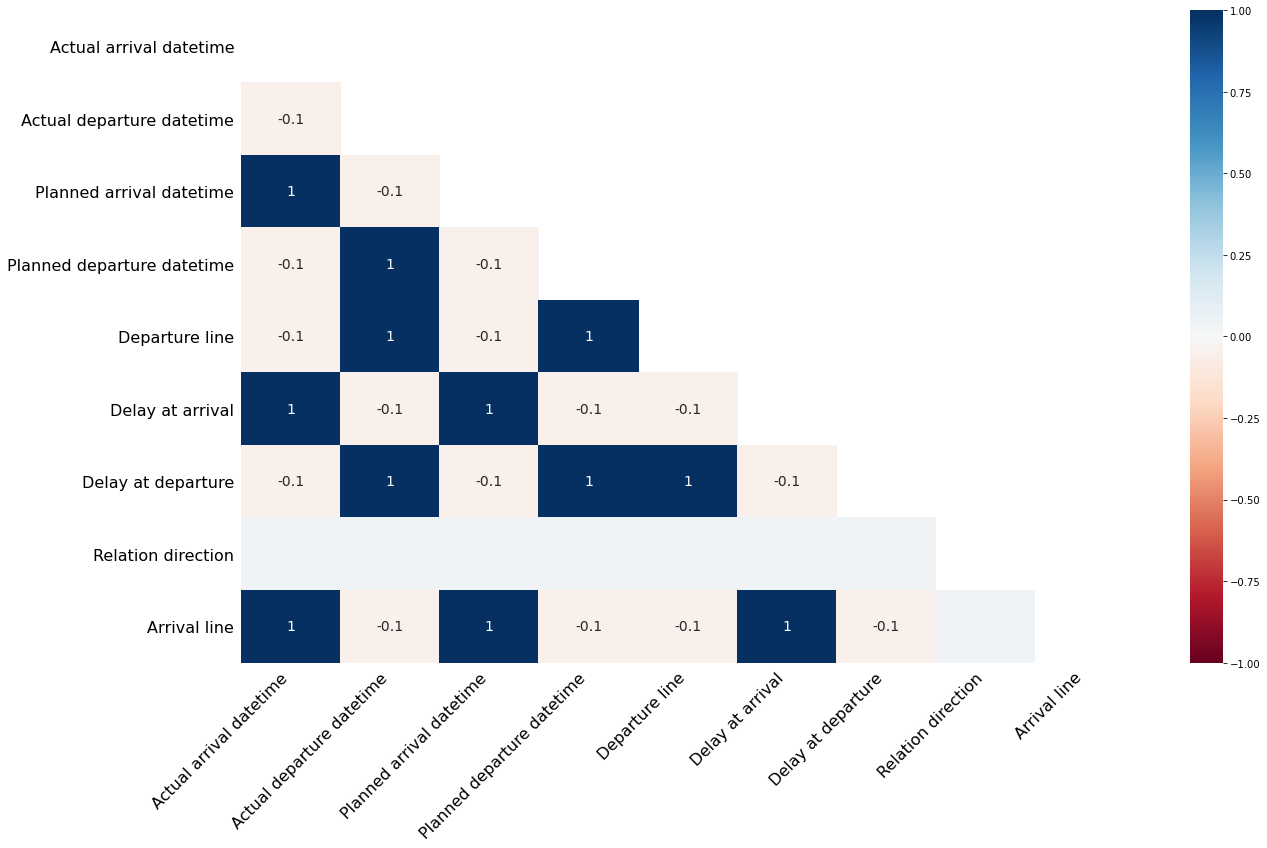

In [6]:
msno.heatmap(df)

According to the total NA's per column and the correlation matrix of NA's, it seems the dataset has three types of missing data:<ol>
    <li>3,526 observations with no information of arrival (maybe they are the first trains of the day or they are a one-way travel).
    <li>3,522 (8 extra for planned departure datetime) observations with no information of departure (maybe they are the last trains of the day).
    <li>5,109 observations with no information about the relation direction. They have data about the relation so, maybe the info is correct because are one-way travels.</ol>

1. <u>Observations with no information of arrival:</u>

In [129]:
#Number of trains with no arrival information
na_arrival =  df['Actual arrival datetime'].isna().sum()

#Number of trains with missing both arrival and relation direction information
na_arrival_nodirection =  df[df['Actual arrival datetime'].isna()]['Relation direction'].isna().sum()

#Percentage of the trains with no arrival info that also lacks relation direction data
nodirection_perc = na_arrival_nodirection * 100 / na_arrival

print(f"""The {nodirection_perc:.2f}% of the observations with no arrival don't have information about relation direction, 
        so they could be one-way travels.""")

The 11.94% of the observations with no arrival don't have information about relation direction, 
        so they could be one-way travels.


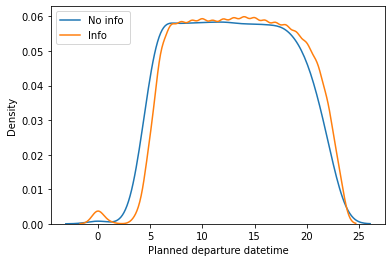

In [108]:
#Planned departure hour for trains with data about relation direction but without arrival information
na_arrival_dephours = df[(df['Actual arrival datetime'].isna())&(~df['Relation direction'].isna())]['Planned departure datetime'].dt.hour

#Planned departure hour for trains with neither information about arrival or relation direction
total_dephours = df[(~df['Actual arrival datetime'].isna())&(~df['Relation direction'].isna())]['Planned departure datetime'].dt.hour

sns.kdeplot(na_arrival_dephours, label="No info ")
sns.kdeplot(total_dephours, label='Info')
plt.legend()

It seems part of the missing arrival information is due to the first trains in the morning. Let's quantify it.

In [130]:
# Number of trains with relation direction and no info of arrival datetime
no_arrivalinfo = df[(df['Actual arrival datetime'].isna())&(~df['Relation direction'].isna())].shape[0]
                                                                                                
# Number of trains with relation direction, no info of arrival datetime, and planned departure before 6 am.
no_arrivalinfo_before6 = (df[(df['Actual arrival datetime'].isna())&(~df['Relation direction'].isna())]['Planned departure datetime'].dt.hour < 6).sum()

# Number of trains with relation direction and info of arrival datetime
arrivalinfo = df[(~df['Actual arrival datetime'].isna())&(~df['Relation direction'].isna())].shape[0]

# Number of trains with relation direction, no info of arrival datetime, and planned departure before 6 am.
arrivalinfo_before6 = (df[(~df['Actual arrival datetime'].isna())&(~df['Relation direction'].isna())]['Planned departure datetime'].dt.hour < 6).sum()

perc_noinfo_before6 = no_arrivalinfo_before6 * 100 / no_arrivalinfo
perc_info_before6 = arrivalinfo_before6 * 100 / arrivalinfo


print(f"""Excluding trains with no relation direction info (possible one-way travels as discussed in the previous point),
the percentage of trains with a planned departure before 6 am is {perc_noinfo_before6:.2f}% for trains with no arrival
datetime info, while the percentage for those trains with arrival datetime info is {perc_info_before6:.2f}%.""")


Excluding trains with no relation direction info (possible one-way travels as discussed in the previous point),
the percentage of trains with a planned departure before 6 am is 6.73% for trains with no arrival
datetime info, while the percentage for those trains with arrival datetime info is 3.20%.


So, around 15% of the missind arrival data could be due to one-way travels or first trains in the day. 
